In [52]:
import xarray as xr
import dask.array as da
import rioxarray
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import geopandas as gpd
import scipy.stats as stats
import numpy as np
from shapely.geometry import mapping

# Load data

In [2]:
import os
DATA_DIR = "/home/mitchhung/data/geog256"
os.listdir(DATA_DIR)

['era5_derived_daily.zarr',
 'fire_perimeters',
 'dfmc.zarr',
 'era5_hourly.tar.gz',
 'era5_derived_hourly.zarr']

### Load perimeters

In [3]:
os.listdir(f"{DATA_DIR}/fire_perimeters")

['WFIGS_Interagency_Perimeters_YearToDate_7244446855919551728.geojson']

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_DeleteThis,poly_FeatureAccess,poly_FeatureStatus,poly_IsVisible,...,attr_CreatedOnDateTime_dt,attr_ModifiedOnDateTime_dt,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,attr_IncidentComplexityLevel,geometry
11,36398,172,PALISADES,Wildfire Daily Fire Perimeter,IR Image Interpretation,23448.000000,No,Public,Approved,Yes,...,"Tue, 07 Jan 2025 19:23:56 GMT","Wed, 29 Jan 2025 01:51:24 GMT",IRWIN,0.0,None,None,{35C19D7C-FEDA-42F8-AD76-9B094E783801},2a11c9e3-3295-4623-8c53-4e9a192ae0f3,Type 3 Incident,"MULTIPOLYGON (((-118.56093 34.04408, -118.5609..."
13,36410,615,Eaton,Wildfire Daily Fire Perimeter,Mixed Methods,14021.108712,No,Public,Approved,Yes,...,"Wed, 08 Jan 2025 02:22:48 GMT","Wed, 29 Jan 2025 01:37:21 GMT",IRWIN,0.0,None,None,{DB7CE9EC-16E0-4513-93D5-95E12703F2F9},52bfca63-1058-40fe-a4b8-ec17b36361c1,Type 4 Incident,"MULTIPOLYGON (((-118.08301 34.23769, -118.0830..."


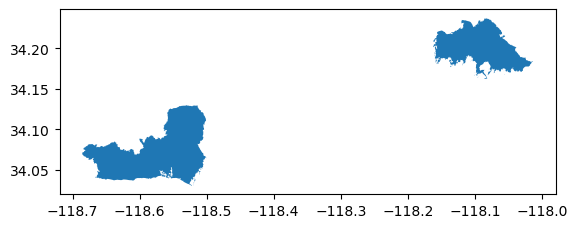

In [4]:
gdf = (
    gpd.read_file(f"{DATA_DIR}/fire_perimeters/{os.listdir(f"{DATA_DIR}/fire_perimeters")[0]}")
    .loc[lambda df: df.poly_IncidentName.isin(["PALISADES", "Eaton"])]
    .to_crs("EPSG:4326")
)
gdf.plot()
gdf.head()

### Load and format raw ERA5 data

In [5]:
LA_BOUNDING_BOX = {
    "lat_min": 33.5,  # Southernmost point
    "lat_max": 34.8,  # Northernmost point
    "lon_min": -119.0, # Westernmost point
    "lon_max": -117.5  # Easternmost point
}

def filter_dataset_by_bbox(ds, lat_min, lat_max, lon_min, lon_max):
    return ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

In [7]:
era5_ds = xr.open_dataset(f"{DATA_DIR}/era5_derived_hourly.zarr", chunks="auto").sortby("latitude")
era5_ds = filter_dataset_by_bbox(
    era5_ds,
    **LA_BOUNDING_BOX,
)
era5_ds = era5_ds.rio.write_crs("EPSG:4326")
era5_ds

<xarray.Dataset> Size: 753MB
Dimensions:      (latitude: 6, valid_time: 648988, longitude: 6)
Coordinates:
  * latitude     (latitude) float64 48B 33.53 33.78 34.03 34.28 34.53 34.78
  * longitude    (longitude) float64 48B -118.9 -118.7 -118.4 ... -117.9 -117.7
  * valid_time   (valid_time) datetime64[ns] 5MB 1951-01-01 ... 2025-01-13T03...
    spatial_ref  int64 8B 0
Data variables:
    tp           (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    fosberg      (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    u10          (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    t2m          (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    v10          (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    wind         (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    rh           (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
    d2m          (valid_time, latitude, longitude) float32 93MB dask.array<chunksize=(43000, 6, 6), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-16T21:06 GRIB to CDM+CF via cfgrib-0.9.1...

# Mask ERA5 data for Eaton and Palisades fires

In [8]:
masks = []

# Iterate over each fire perimeter
for _, row in gdf.iterrows():
    fire_name = row.poly_IncidentName
    fire_geom = row.geometry
    clipped = era5_ds.rio.clip([mapping(fire_geom)], era5_ds.rio.crs, drop=True, all_touched=True)
    masks.append(clipped[["latitude", "longitude"]].to_dataframe().assign(fire_name=fire_name))

mask_df = pd.concat(masks).reset_index()
mask_df

,latitude,longitude,spatial_ref,fire_name
0,34.03,-118.65,0,PALISADES
1,34.03,-118.40,0,PALISADES
2,34.28,-118.15,0,Eaton
3,34.28,-117.90,0,Eaton


In [9]:
pal_ds = era5_ds.where(
    ((era5_ds.latitude == 34.03) & (era5_ds.longitude == -118.4)) |
    ((era5_ds.latitude == 34.03) & (era5_ds.longitude == -118.65)),
    drop=True
)

eat_ds = era5_ds.where(
    ((era5_ds.latitude == 34.28) & (era5_ds.longitude == -118.15)) |
    ((era5_ds.latitude == 34.28) & (era5_ds.longitude == -117.9)),
    drop=True
)
pal_ds

<xarray.Dataset> Size: 47MB
Dimensions:      (valid_time: 648988, latitude: 1, longitude: 2)
Coordinates:
  * latitude     (latitude) float64 8B 34.03
  * longitude    (longitude) float64 16B -118.7 -118.4
  * valid_time   (valid_time) datetime64[ns] 5MB 1951-01-01 ... 2025-01-13T03...
    spatial_ref  int64 8B 0
Data variables:
    tp           (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    fosberg      (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    u10          (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    t2m          (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    v10          (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    wind         (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    rh           (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
    d2m          (valid_time, latitude, longitude) float32 5MB dask.array<chunksize=(43000, 1, 2), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-16T21:06 GRIB to CDM+CF via cfgrib-0.9.1...

# Aggregate to daily

In [10]:
def daily_resample(ds):
    wind_mean = ds["wind"].resample(valid_time="1D").mean()
    avg_u10 = ds["u10"].resample(valid_time="1D").mean()
    avg_v10 = ds["v10"].resample(valid_time="1D").mean()
    wind = ds["wind"].resample(valid_time="1D").mean()
    ffwi = ds["fosberg"].resample(valid_time="1D").mean()

    ###  mean standardized wind direction is between north-northwest (330 deg) 
    # and clockwise to south-southeast (120 deg)
    wind_direction = (np.arctan2(-avg_u10, -avg_v10) * (180 / da.pi)) % 360
    wind_mask = ((wind_direction >= 330) | (wind_direction <= 120))
    wind_indicator = wind_mask.astype(np.uint8)
    
    ds = xr.Dataset({
        "wind_mean": wind,
        "u10": avg_u10,
        "v10": avg_v10,
        "wind": wind,
        "ffwi": ffwi,
        "condition_2": wind_indicator,
    })
    return ds

pal_ds = daily_resample(pal_ds)
eat_ds = daily_resample(eat_ds)
eat_ds

<xarray.Dataset> Size: 1MB
Dimensions:      (latitude: 1, longitude: 2, valid_time: 27042)
Coordinates:
  * latitude     (latitude) float64 8B 34.28
  * longitude    (longitude) float64 16B -118.2 -117.9
    spatial_ref  int64 8B 0
  * valid_time   (valid_time) datetime64[ns] 216kB 1951-01-01 ... 2025-01-13
Data variables:
    wind_mean    (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    u10          (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    v10          (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    wind         (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    ffwi         (valid_time, latitude, longitude) float32 216kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>
    condition_2  (valid_time, latitude, longitude) uint8 54kB dask.array<chunksize=(1792, 1, 2), meta=np.ndarray>

# Get 90th and 97th percentiles for FFWI

In [11]:
pal_sm = pal_ds.ffwi.mean(dim=["latitude", "longitude"])
pal_q90 = pal_sm.quantile(0.90, dim="valid_time")
pal_q97 = pal_sm.quantile(0.97, dim="valid_time")

eat_sm = eat_ds.ffwi.mean(dim=["latitude", "longitude"])
eat_q90 = eat_sm.quantile(0.90, dim="valid_time")
eat_q97 = eat_sm.quantile(0.97, dim="valid_time")

def assign_quantile_conditions(ds, q90, q97):
    return (
        ds.mean(dim=["latitude", "longitude"]).assign(
            condition_1=lambda ds: (ds.ffwi >= q90.values),
            condition_1_extreme=lambda ds: (ds.ffwi >= q97.values),
        )
    )

pal_ds = assign_quantile_conditions(pal_ds, pal_q90, pal_q97)
eat_ds = assign_quantile_conditions(eat_ds, eat_q90, eat_q97)
eat_ds


<xarray.Dataset> Size: 1MB
Dimensions:              (valid_time: 27042)
Coordinates:
    spatial_ref          int64 8B 0
  * valid_time           (valid_time) datetime64[ns] 216kB 1951-01-01 ... 202...
Data variables:
    wind_mean            (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    u10                  (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    v10                  (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    wind                 (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    ffwi                 (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    condition_2          (valid_time) float64 216kB dask.array<chunksize=(1792,), meta=np.ndarray>
    condition_1          (valid_time) bool 27kB dask.array<chunksize=(1792,), meta=np.ndarray>
    condition_1_extreme  (valid_time) bool 27kB dask.array<chunksize=(1792,), meta=np.ndarray>

In [12]:
eat_df = eat_ds[["valid_time", "wind", "condition_1", "condition_1_extreme", "condition_2"]].to_dataframe()
pal_df = pal_ds[["valid_time", "wind", "condition_1", "condition_1_extreme", "condition_2"]].to_dataframe()

analysis_df = (
    pd.concat([
        eat_df.assign(fire_name="Eaton"),
        pal_df.assign(fire_name="Palisades"),
    ])
    .assign(
        saw_day=lambda df: (df.condition_1) & (df.condition_2),
        esaw_day=lambda df: (df.condition_1_extreme) & (df.condition_2),
    )
)
analysis_df.head()

,wind,condition_1,condition_1_extreme,condition_2,spatial_ref,fire_name,saw_day,esaw_day
valid_time,,,,,,,,
1951-01-01,2.628524,True,False,1.0,0,Eaton,True,False
1951-01-02,1.664387,False,False,1.0,0,Eaton,False,False
1951-01-03,1.125025,False,False,0.0,0,Eaton,False,False
1951-01-04,1.038689,False,False,0.0,0,Eaton,False,False
1951-01-05,1.049835,False,False,1.0,0,Eaton,False,False


# Palisades

In [13]:
sub_df = analysis_df.loc[lambda df: df.fire_name == "Palisades"].reset_index()
sub_df

,valid_time,wind,condition_1,condition_1_extreme,condition_2,spatial_ref,fire_name,saw_day,esaw_day
0,1951-01-01,3.189638,True,False,1.0,0,Palisades,True,False
1,1951-01-02,2.281070,False,False,1.0,0,Palisades,False,False
2,1951-01-03,1.333098,False,False,0.5,0,Palisades,False,False
3,1951-01-04,1.857749,False,False,0.0,0,Palisades,False,False
4,1951-01-05,1.489351,False,False,1.0,0,Palisades,False,False
...,...,...,...,...,...,...,...,...,...
27037,2025-01-09,2.725553,True,False,1.0,0,Palisades,True,False
27038,2025-01-10,2.328828,True,False,1.0,0,Palisades,True,False
27039,2025-01-11,1.732618,False,False,1.0,0,Palisades,False,False
27040,2025-01-12,3.283114,True,True,1.0,0,Palisades,True,True


/tmp/ipykernel_2548106/3578474972.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")


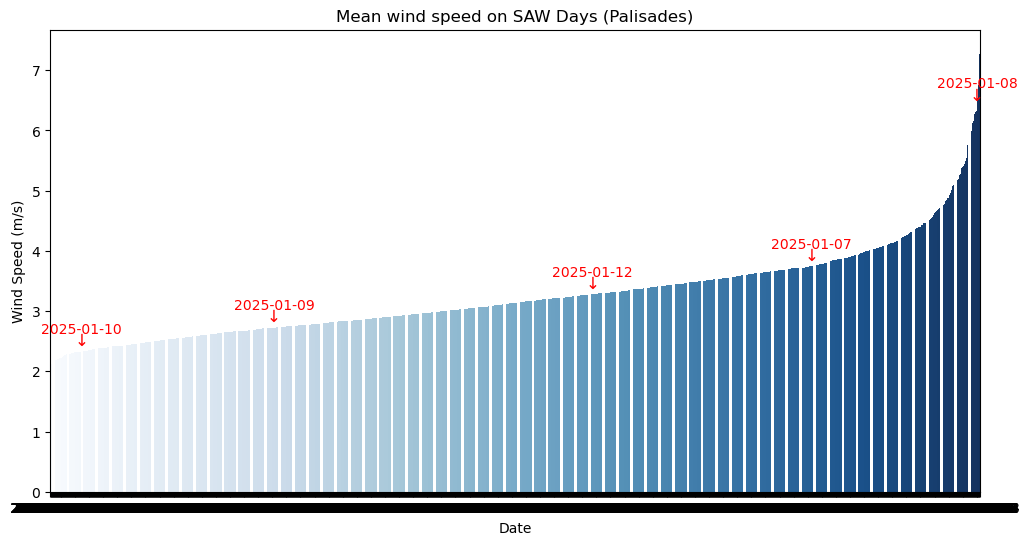

In [14]:
# Convert valid_time to datetime if not already
sub_df["valid_time"] = pd.to_datetime(sub_df["valid_time"])

# Filter & sort by wind
sub_df_sorted = sub_df.loc[lambda df: df.saw_day == 1].sort_values("wind", ascending=True)

# Convert valid_time to string for plotting
sub_df_sorted["valid_time_str"] = sub_df_sorted["valid_time"].dt.strftime("%Y-%m-%d")

# Identify points between 2025-01-01 and 2025-01-14
highlight_points = sub_df_sorted[
    (sub_df_sorted["valid_time"] >= "2025-01-01") & 
    (sub_df_sorted["valid_time"] <= "2025-01-14")
]

# Set figure size
plt.figure(figsize=(12, 6))

# Create a bar plot using string-based x-axis
ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")

# Add small red arrows to highlight points
for index, row in highlight_points.iterrows():
    plt.annotate(
        "↓", 
        (row["valid_time_str"], row["wind"] + 0.1),  # Position slightly above the bar
        color="red", fontsize=12, ha='center'
    )
    # Add the date label in condensed format (MM-DD)
    plt.annotate(
        row["valid_time"].strftime("%Y-%m-%d"),
        (row["valid_time_str"], row["wind"] + 0.3),  # Slightly above the arrow
        color="red", fontsize=10, ha='center'
    )

# Formatting
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.title("Mean wind speed on SAW Days (Palisades)")
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability

plt.savefig("paliades_saw.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

/tmp/ipykernel_2548106/1035010081.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")


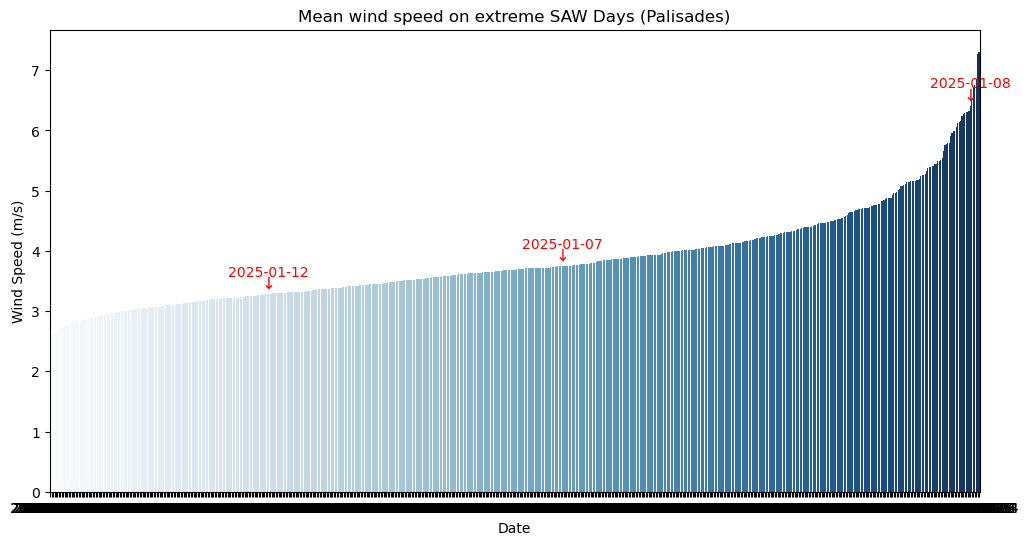

In [15]:
# Convert valid_time to datetime if not already
sub_df["valid_time"] = pd.to_datetime(sub_df["valid_time"])

# Filter & sort by wind
sub_df_sorted = sub_df.loc[lambda df: df.esaw_day == 1].sort_values("wind", ascending=True)

# Convert valid_time to string for plotting
sub_df_sorted["valid_time_str"] = sub_df_sorted["valid_time"].dt.strftime("%Y-%m-%d")

# Identify points between 2025-01-01 and 2025-01-14
highlight_points = sub_df_sorted[
    (sub_df_sorted["valid_time"] >= "2025-01-01") & 
    (sub_df_sorted["valid_time"] <= "2025-01-14")
]

# Set figure size
plt.figure(figsize=(12, 6))

# Create a bar plot using string-based x-axis
ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")

# Add small red arrows to highlight points
for index, row in highlight_points.iterrows():
    plt.annotate(
        "↓", 
        (row["valid_time_str"], row["wind"] + 0.1),  # Position slightly above the bar
        color="red", fontsize=12, ha='center'
    )
    # Add the date label in condensed format (MM-DD)
    plt.annotate(
        row["valid_time"].strftime("%Y-%m-%d"),
        (row["valid_time_str"], row["wind"] + 0.3),  # Slightly above the arrow
        color="red", fontsize=10, ha='center'
    )

# Formatting
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.title("Mean wind speed on extreme SAW Days (Palisades)")
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability

plt.savefig("paliades_esaw.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

# Eaton

In [16]:
sub_df = analysis_df.loc[lambda df: df.fire_name == "Eaton"].reset_index()
sub_df

,valid_time,wind,condition_1,condition_1_extreme,condition_2,spatial_ref,fire_name,saw_day,esaw_day
0,1951-01-01,2.628524,True,False,1.0,0,Eaton,True,False
1,1951-01-02,1.664387,False,False,1.0,0,Eaton,False,False
2,1951-01-03,1.125025,False,False,0.0,0,Eaton,False,False
3,1951-01-04,1.038689,False,False,0.0,0,Eaton,False,False
4,1951-01-05,1.049835,False,False,1.0,0,Eaton,False,False
...,...,...,...,...,...,...,...,...,...
27037,2025-01-09,2.741091,True,True,1.0,0,Eaton,True,True
27038,2025-01-10,2.288334,True,False,1.0,0,Eaton,True,False
27039,2025-01-11,1.438421,False,False,1.0,0,Eaton,False,False
27040,2025-01-12,2.708519,True,True,1.0,0,Eaton,True,True


/tmp/ipykernel_2548106/38864947.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")


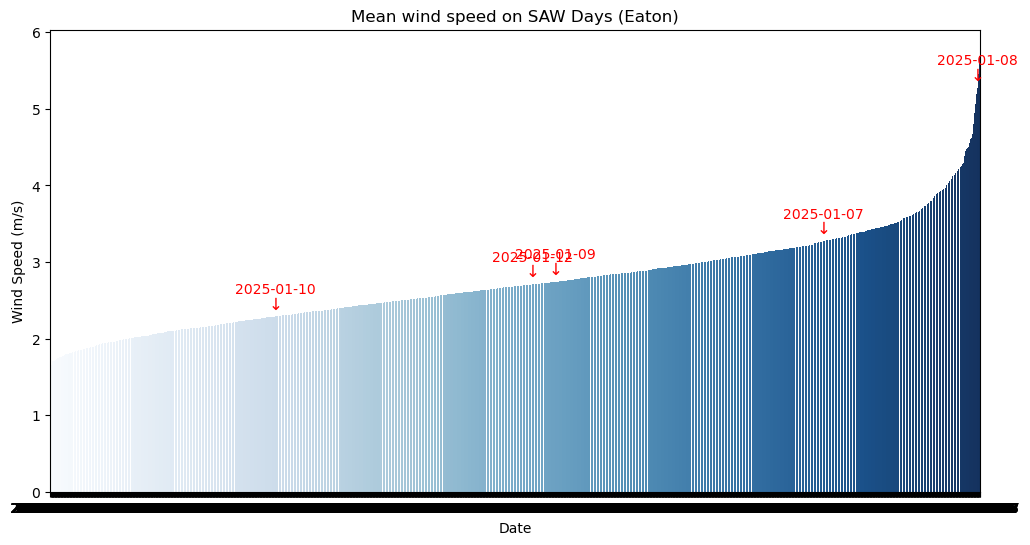

In [17]:
# Convert valid_time to datetime if not already
sub_df["valid_time"] = pd.to_datetime(sub_df["valid_time"])

# Filter & sort by wind
sub_df_sorted = sub_df.loc[lambda df: df.saw_day == 1].sort_values("wind", ascending=True)

# Convert valid_time to string for plotting
sub_df_sorted["valid_time_str"] = sub_df_sorted["valid_time"].dt.strftime("%Y-%m-%d")

# Identify points between 2025-01-01 and 2025-01-14
highlight_points = sub_df_sorted[
    (sub_df_sorted["valid_time"] >= "2025-01-01") & 
    (sub_df_sorted["valid_time"] <= "2025-01-14")
]

# Set figure size
plt.figure(figsize=(12, 6))

# Create a bar plot using string-based x-axis
ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")

# Add small red arrows to highlight points
for index, row in highlight_points.iterrows():
    plt.annotate(
        "↓", 
        (row["valid_time_str"], row["wind"] + 0.1),  # Position slightly above the bar
        color="red", fontsize=12, ha='center'
    )
    # Add the date label in condensed format (MM-DD)
    plt.annotate(
        row["valid_time"].strftime("%Y-%m-%d"),
        (row["valid_time_str"], row["wind"] + 0.3),  # Slightly above the arrow
        color="red", fontsize=10, ha='center'
    )

# Formatting
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.title("Mean wind speed on SAW Days (Eaton)")
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.savefig("eaton_saw.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

/tmp/ipykernel_2548106/3612088773.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")


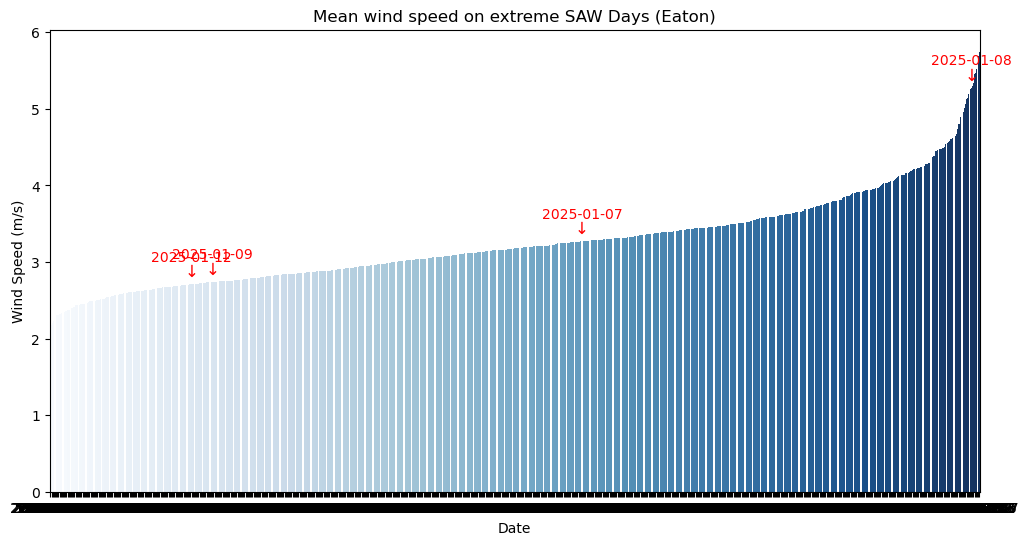

In [18]:
# Convert valid_time to datetime if not already
sub_df["valid_time"] = pd.to_datetime(sub_df["valid_time"])

# Filter & sort by wind
sub_df_sorted = sub_df.loc[lambda df: df.esaw_day == 1].sort_values("wind", ascending=True)

# Convert valid_time to string for plotting
sub_df_sorted["valid_time_str"] = sub_df_sorted["valid_time"].dt.strftime("%Y-%m-%d")

# Identify points between 2025-01-01 and 2025-01-14
highlight_points = sub_df_sorted[
    (sub_df_sorted["valid_time"] >= "2025-01-01") & 
    (sub_df_sorted["valid_time"] <= "2025-01-14")
]

# Set figure size
plt.figure(figsize=(12, 6))

# Create a bar plot using string-based x-axis
ax = sns.barplot(x="valid_time_str", y="wind", data=sub_df_sorted, palette="Blues")

# Add small red arrows to highlight points
for index, row in highlight_points.iterrows():
    plt.annotate(
        "↓", 
        (row["valid_time_str"], row["wind"] + 0.1),  # Position slightly above the bar
        color="red", fontsize=12, ha='center'
    )
    # Add the date label in condensed format (MM-DD)
    plt.annotate(
        row["valid_time"].strftime("%Y-%m-%d"),
        (row["valid_time_str"], row["wind"] + 0.3),  # Slightly above the arrow
        color="red", fontsize=10, ha='center'
    )

# Formatting
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.title("Mean wind speed on extreme SAW Days (Eaton)")
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.savefig("eaton_esaw.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

# Probability analysis

### Load data

In [29]:
# era5_ds
dfmc_ds = xr.open_dataset(f"{DATA_DIR}/dfmc.zarr", chunks="auto")

pal_ds = era5_ds.where(
    ((era5_ds.latitude == 34.03) & (era5_ds.longitude == -118.4)) |
    ((era5_ds.latitude == 34.03) & (era5_ds.longitude == -118.65)),
    drop=True
)

eat_ds = era5_ds.where(
    ((era5_ds.latitude == 34.28) & (era5_ds.longitude == -118.15)) |
    ((era5_ds.latitude == 34.28) & (era5_ds.longitude == -117.9)),
    drop=True
)


def preprocess_for_prob_analysis(ds, dfmc):
    ds = daily_resample(ds)
    ds = xr.merge([ds, dfmc], how="left")
    sm = ds.ffwi.mean(dim=["latitude", "longitude"])
    q90 = sm.quantile(0.90, dim="valid_time")
    q97 = sm.quantile(0.97, dim="valid_time")
    ds = assign_quantile_conditions(ds, q90, q97)
    return ds

ppal_ds = preprocess_for_prob_analysis(pal_ds, dfmc_ds)
peat_ds = preprocess_for_prob_analysis(eat_ds, dfmc_ds)
ppal_ds


/home/mitchhung/micromamba/envs/py-3.12-geo/lib/python3.12/site-packages/dask/array/core.py:5039: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mitchhung/micromamba/envs/py-3.12-geo/lib/python3.12/site-packages/dask/array/core.py:5039: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/home/mitchhung/micromamba/envs/py-3.12-geo/lib/python3.12/site-packages/dask/array/core.py:5039: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mitchhung/micromamba/envs/py-3.12-geo/lib/python3.12/site-packages/dask/array/core.py:5039: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/home/mitchhung/micromamba/envs/py-3.12-geo/lib/python3.12/site-packages/dask/array/core.py:5039: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mitchhung/micromamba/envs/py-3.12-geo/lib/python3.12/site-packages/dask/ar

<xarray.Dataset> Size: 1MB
Dimensions:              (valid_time: 27042)
Coordinates:
  * valid_time           (valid_time) datetime64[ns] 216kB 1951-01-01 ... 202...
    spatial_ref          int64 8B 0
Data variables:
    wind_mean            (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    u10                  (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    v10                  (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    wind                 (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    ffwi                 (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    condition_2          (valid_time) float32 108kB dask.array<chunksize=(1792,), meta=np.ndarray>
    fm1000               (valid_time) float64 216kB dask.array<chunksize=(20286,), meta=np.ndarray>
    fm100                (valid_time) float64 216kB dask.array<chunksize=(20286,), meta=np.ndarray>
    condition_1          (valid_time) bool 27kB dask.array<chunksize=(1792,), meta=np.ndarray>
    condition_1_extreme  (valid_time) bool 27kB dask.array<chunksize=(1792,), meta=np.ndarray>

In [39]:
VARS = ["valid_time", "wind", "fm1000", "fm100", "condition_1", "condition_1_extreme", "condition_2"]

eat_df = peat_ds[VARS].to_dataframe()
pal_df = ppal_ds[VARS].to_dataframe()

analysis_df = (
    pd.concat([
        eat_df.assign(fire_name="Eaton"),
        pal_df.assign(fire_name="Palisades"),
    ])
    .assign(
        saw_day=lambda df: (df.condition_1) & (df.condition_2),
        esaw_day=lambda df: (df.condition_1_extreme) & (df.condition_2),
    )
    .reset_index()
    .loc[lambda df: df.valid_time >= "1980-01-01"]
)
analysis_df.head()

,valid_time,wind,fm1000,fm100,condition_1,condition_1_extreme,condition_2,spatial_ref,fire_name,saw_day,esaw_day
10592,1980-01-01,1.504502,15.102136,14.222466,False,False,1.0,0,Eaton,False,False
10593,1980-01-02,2.077217,14.923872,12.848037,False,False,1.0,0,Eaton,False,False
10594,1980-01-03,1.793304,14.842542,11.600677,False,False,1.0,0,Eaton,False,False
10595,1980-01-04,0.893990,14.770342,11.100124,False,False,0.5,0,Eaton,False,False
10596,1980-01-05,1.059636,14.961513,11.371608,False,False,0.5,0,Eaton,False,False


### Eaton

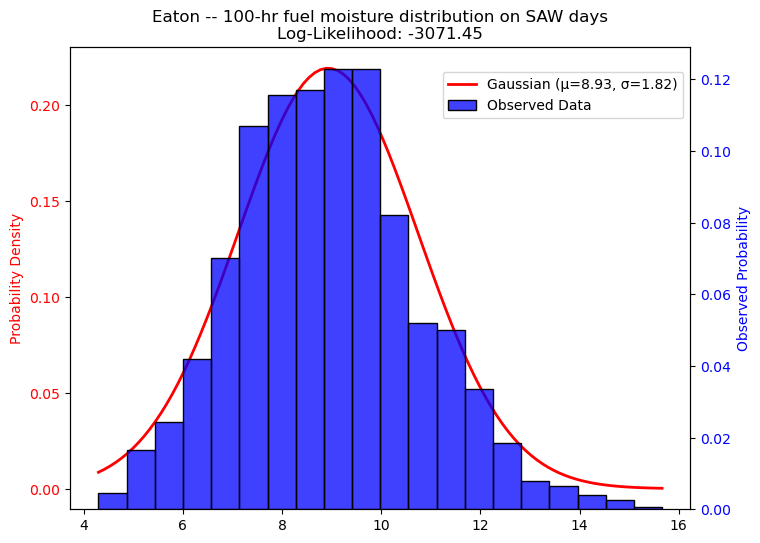

In [142]:
subset = analysis_df.loc[(analysis_df["fire_name"] == "Eaton") & (analysis_df["condition_1"] == 1)]
var = "fm100"

# Fit Gaussian (normal) distribution
mu, sigma = np.mean(subset[var]), np.std(subset[var])  # Estimate mean and std dev

# Generate x values for smooth curve
x = np.linspace(subset[var].min(), subset[var].max(), 100)
pdf = stats.norm.pdf(x, mu, sigma)  # Probability Density Function

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Left y-axis: Fitted Gaussian Distribution
ax1.plot(x, pdf, label=f"Gaussian (μ={mu:.2f}, σ={sigma:.2f})", color="red", lw=2)
ax1.set_ylabel("Probability Density", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create right y-axis for observed data
ax2 = ax1.twinx()
sns.histplot(subset, x=var, stat="probability", kde=False, bins=20, label="Observed Data", color="blue", ax=ax2)
ax2.set_ylabel("Observed Probability", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Compute log-likelihood
log_likelihood = np.sum(stats.norm.logpdf(subset[var], mu, sigma))

# Add title
plt.title(f"Eaton -- 100-hr fuel moisture distribution on SAW days\nLog-Likelihood: {log_likelihood:.2f}")

# Show legend
# fig.legend(loc="upper right", bbox_to_anchor=(1, 1))
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))

plt.xlabel("100-hr Fuel Moisture (fm100)")
plt.savefig("eaton_100hr_dist.png", dpi=300, bbox_inches="tight")
plt.show()



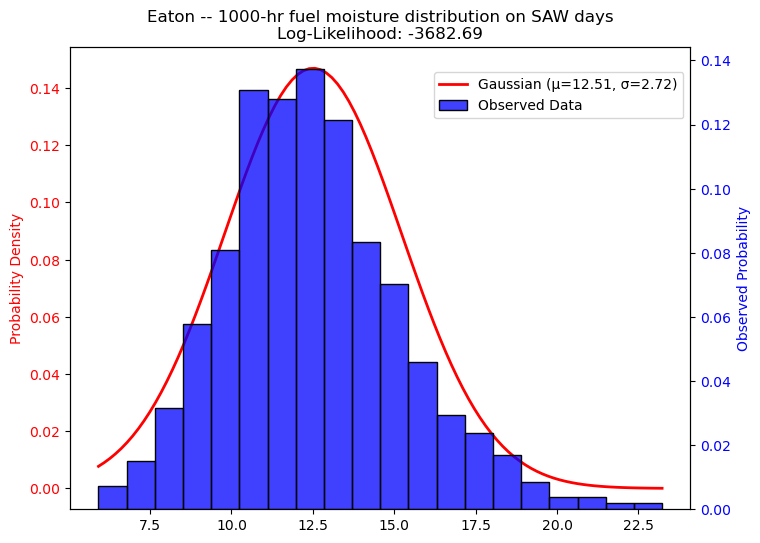

In [143]:
subset = analysis_df.loc[(analysis_df["fire_name"] == "Eaton") & (analysis_df["condition_1"] == 1)]
var = "fm1000"

# Fit Gaussian (normal) distribution
mu, sigma = np.mean(subset[var]), np.std(subset[var])  # Estimate mean and std dev

# Generate x values for smooth curve
x = np.linspace(subset[var].min(), subset[var].max(), 100)
pdf = stats.norm.pdf(x, mu, sigma)  # Probability Density Function

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Left y-axis: Fitted Gaussian Distribution
ax1.plot(x, pdf, label=f"Gaussian (μ={mu:.2f}, σ={sigma:.2f})", color="red", lw=2)
ax1.set_ylabel("Probability Density", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create right y-axis for observed data
ax2 = ax1.twinx()
sns.histplot(subset, x=var, stat="probability", kde=False, bins=20, label="Observed Data", color="blue", ax=ax2)
ax2.set_ylabel("Observed Probability", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Compute log-likelihood
log_likelihood = np.sum(stats.norm.logpdf(subset[var], mu, sigma))

# Add title
plt.title(f"Eaton -- 1000-hr fuel moisture distribution on SAW days\nLog-Likelihood: {log_likelihood:.2f}")

# Show legend
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))

plt.xlabel("1000-hr Fuel Moisture (fm100)")
plt.savefig("eaton_1000hr_dist.png", dpi=300, bbox_inches="tight")
plt.show()



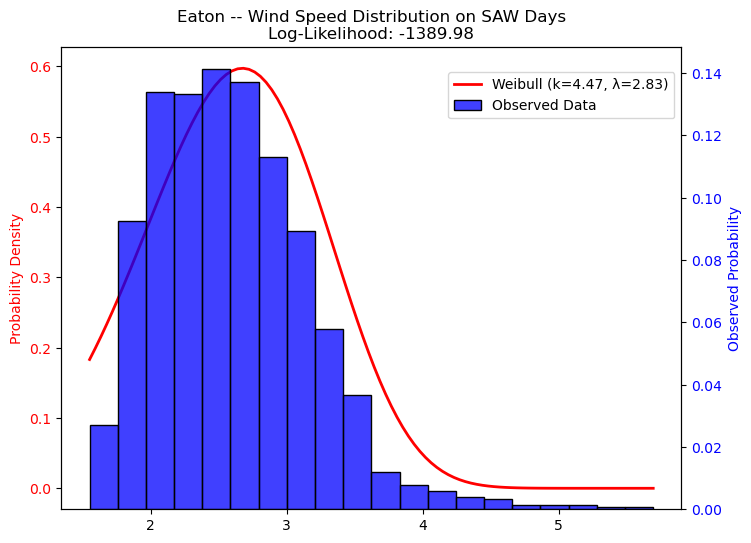

In [144]:
# Extract the relevant data
subset = analysis_df.loc[(analysis_df["fire_name"] == "Eaton") & (analysis_df["condition_1"] == 1)]
var = "wind"  # Variable to fit

# Fit Weibull distribution (MLE)
shape, loc, scale = stats.weibull_min.fit(subset[var], floc=0)  # Fix location at 0

# Generate x values for smooth curve
x = np.linspace(subset[var].min(), subset[var].max(), 100)
pdf = stats.weibull_min.pdf(x, shape, loc, scale)  # Weibull Probability Density Function

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Left y-axis: Fitted Weibull Distribution
ax1.plot(x, pdf, label=f"Weibull (k={shape:.2f}, λ={scale:.2f})", color="red", lw=2)
ax1.set_ylabel("Probability Density", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create right y-axis for observed data
ax2 = ax1.twinx()
sns.histplot(subset, x=var, stat="probability", kde=False, bins=20, label="Observed Data", color="blue", ax=ax2)
ax2.set_ylabel("Observed Probability", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Compute log-likelihood
log_likelihood = np.sum(stats.weibull_min.logpdf(subset[var], shape, loc, scale))

# Add title
plt.title(f"Eaton -- Wind Speed Distribution on SAW Days\nLog-Likelihood: {log_likelihood:.2f}")

# Move the legend inside the plot at the top-right
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))

plt.xlabel("Wind Speed (m/s)")
plt.savefig("eaton_wind_dist.png", dpi=300, bbox_inches="tight")
plt.show()


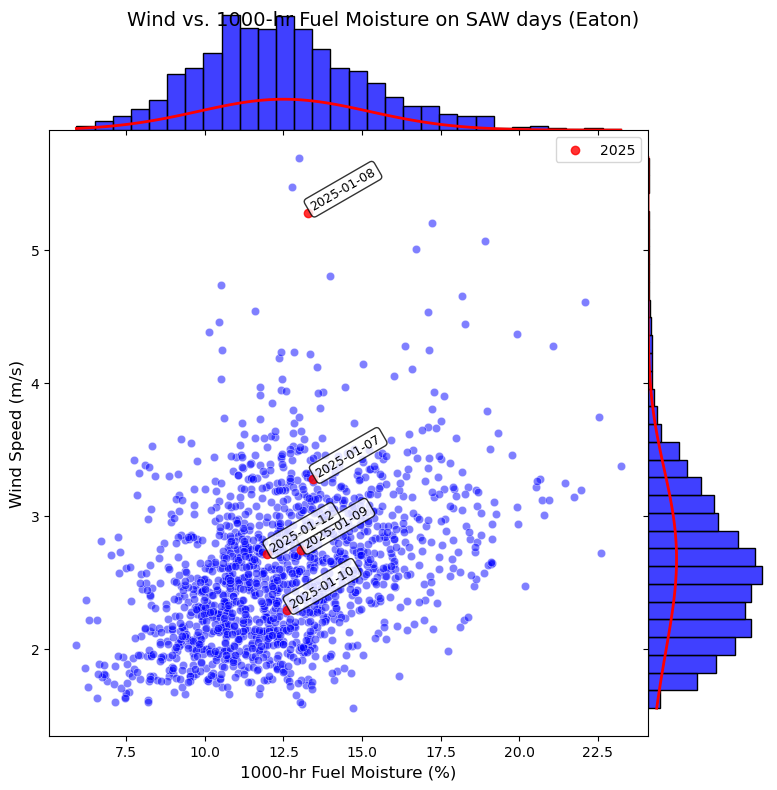

In [145]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Subset data
subset = analysis_df.loc[(analysis_df["fire_name"] == "Eaton") & (analysis_df["condition_1"] == 1)]
y_var, x_var = "wind", "fm1000"

# Separate 2025 data points
subset_2025 = subset[subset["valid_time"] >= "2025-01-01"]
subset_other = subset[subset["valid_time"] < "2025-01-01"]

# fit dfmc
mu_x, sigma_x = np.mean(subset[x_var]), np.std(subset[x_var])
x_vals = np.linspace(subset[x_var].min(), subset[x_var].max(), 100)
pdf_x = stats.norm.pdf(x_vals, mu_x, sigma_x) 

# fit wind
shape_y, loc_y, scale_y = stats.weibull_min.fit(subset[y_var], floc=0)  
y_vals = np.linspace(subset[y_var].min(), subset[y_var].max(), 100)
pdf_y = stats.weibull_min.pdf(y_vals, shape_y, loc_y, scale_y)  

# Create Joint Plot
g = sns.jointplot(data=subset_other, x=x_var, y=y_var, kind="scatter", height=8, space=0, color="blue", alpha=0.5)

# Overlay 2025 data points in red
g.ax_joint.scatter(subset_2025[x_var], subset_2025[y_var], color="red", alpha=0.8, label="2025")

# Add date labels to 2025 points
# Add date labels to 2025 points with white background and black border
for _, row in subset_2025.iterrows():
    g.ax_joint.text(
        row[x_var], row[y_var], row["valid_time"].strftime("%Y-%m-%d"), 
        fontsize=9, color="black", 
        ha='left', 
        va='bottom', 
        rotation=30,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3", alpha=0.8)
    )


ax_marg_x = g.ax_marg_x
ax_marg_x.plot(x_vals, pdf_x * np.diff(x_vals)[0] * len(subset), color="red", lw=2, label=f"Gaussian Fit (μ={mu_x:.2f}, σ={sigma_x:.2f})")
ax_marg_x.set_ylabel("Density")

ax_marg_y = g.ax_marg_y
ax_marg_y.plot(pdf_y * np.diff(y_vals)[0] * len(subset), y_vals, color="red", lw=2, label=f"Weibull Fit (k={shape_y:.2f}, λ={scale_y:.2f})")
ax_marg_y.set_xlabel("Density")

g.set_axis_labels("1000-hr Fuel Moisture (%)", "Wind Speed (m/s)", fontsize=12)
plt.suptitle("Wind vs. 1000-hr Fuel Moisture on SAW days (Eaton)", fontsize=14)
g.ax_joint.legend()
plt.savefig("eaton_joint_dist.png", dpi=300, bbox_inches="tight")
plt.show()

In [147]:
# Extract 2025-01-08 data point
target_date = "2025-01-08"
target_row = subset_2025[subset_2025["valid_time"] == target_date]

if not target_row.empty:
    target_wind = target_row[y_var].values[0]  # Wind speed value
    target_fm1000 = target_row[x_var].values[0]  # Fuel moisture value

    # Compute cumulative probabilities
    fm1000_cdf = stats.norm.cdf(target_fm1000, mu_x, sigma_x)  # P(FM1000 <= target_fm1000)
    wind_cdf = stats.weibull_min.cdf(target_wind, shape_y, loc_y, scale_y)  # P(Wind <= target_wind)

    # Compute complementary probabilities
    p_fm1000_higher = 1 - fm1000_cdf  # P(FM1000 > target_fm1000)
    p_wind_lower = wind_cdf  # P(Wind < target_wind)

    # Compute joint probability (assuming independence)
    combined_probability = (1-p_fm1000_higher) * (1-p_wind_lower)

    # Display results
    print(f"P(FM1000 < {target_fm1000:.2f}%) = {1-p_fm1000_higher:.6f}")
    print(f"P(Wind > {target_wind:.2f} m/s) = {1-p_wind_lower:.2e}")
    print(f"Joint Probability: {combined_probability:.6e}")

else:
    print(f"No data found for {target_date}.")

P(FM1000 < 13.29%) = 0.612769
P(Wind > 5.28 m/s) = 9.15e-08
Joint Probability: 5.609344e-08


In [126]:
stats.norm.pdf(mu_x, mu_x, sigma_x)

np.float64(0.14689314387412916)

### Palisades

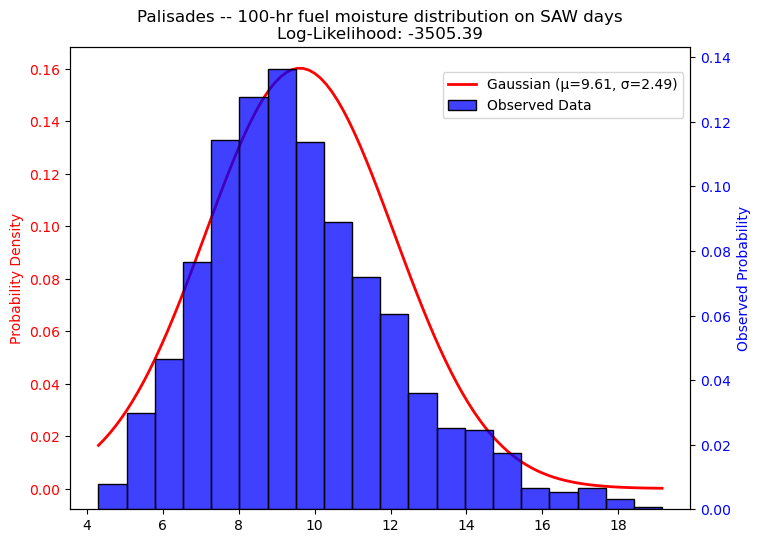

In [137]:
subset = analysis_df.loc[(analysis_df["fire_name"] == "Palisades") & (analysis_df["condition_1"] == 1)]
var = "fm100"

# Fit Gaussian (normal) distribution
mu, sigma = np.mean(subset[var]), np.std(subset[var])  # Estimate mean and std dev

# Generate x values for smooth curve
x = np.linspace(subset[var].min(), subset[var].max(), 100)
pdf = stats.norm.pdf(x, mu, sigma)  # Probability Density Function

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Left y-axis: Fitted Gaussian Distribution
ax1.plot(x, pdf, label=f"Gaussian (μ={mu:.2f}, σ={sigma:.2f})", color="red", lw=2)
ax1.set_ylabel("Probability Density", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create right y-axis for observed data
ax2 = ax1.twinx()
sns.histplot(subset, x=var, stat="probability", kde=False, bins=20, label="Observed Data", color="blue", ax=ax2)
ax2.set_ylabel("Observed Probability", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Compute log-likelihood
log_likelihood = np.sum(stats.norm.logpdf(subset[var], mu, sigma))

# Add title
plt.title(f"Palisades -- 100-hr fuel moisture distribution on SAW days\nLog-Likelihood: {log_likelihood:.2f}")

# Show legend
# fig.legend(loc="upper right", bbox_to_anchor=(1, 1))
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))

plt.xlabel("100-hr Fuel Moisture (fm100)")
plt.savefig("palisades_100hr_dist.png", dpi=300, bbox_inches="tight")
plt.show()


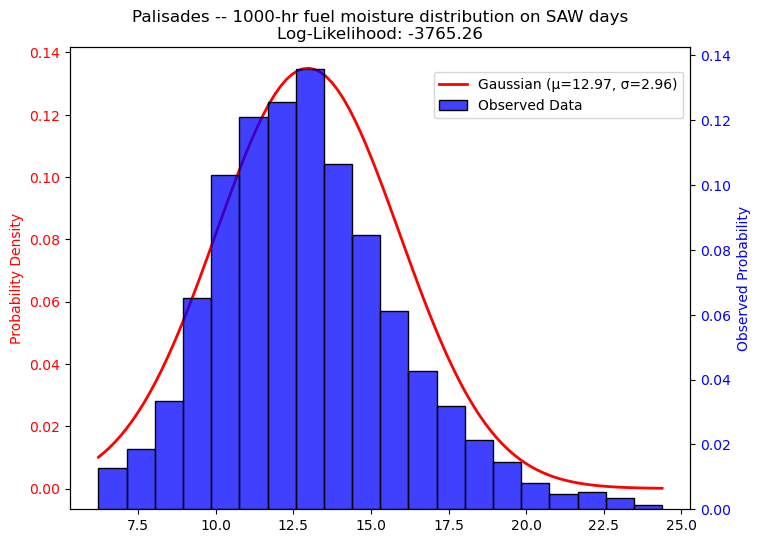

In [138]:
subset = analysis_df.loc[(analysis_df["fire_name"] == "Palisades") & (analysis_df["condition_1"] == 1)]
var = "fm1000"

# Fit Gaussian (normal) distribution
mu, sigma = np.mean(subset[var]), np.std(subset[var])  # Estimate mean and std dev

# Generate x values for smooth curve
x = np.linspace(subset[var].min(), subset[var].max(), 100)
pdf = stats.norm.pdf(x, mu, sigma)  # Probability Density Function

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Left y-axis: Fitted Gaussian Distribution
ax1.plot(x, pdf, label=f"Gaussian (μ={mu:.2f}, σ={sigma:.2f})", color="red", lw=2)
ax1.set_ylabel("Probability Density", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create right y-axis for observed data
ax2 = ax1.twinx()
sns.histplot(subset, x=var, stat="probability", kde=False, bins=20, label="Observed Data", color="blue", ax=ax2)
ax2.set_ylabel("Observed Probability", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Compute log-likelihood
log_likelihood = np.sum(stats.norm.logpdf(subset[var], mu, sigma))

# Add title
plt.title(f"Palisades -- 1000-hr fuel moisture distribution on SAW days\nLog-Likelihood: {log_likelihood:.2f}")

# Show legend
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))

plt.xlabel("1000-hr Fuel Moisture (fm100)")
plt.savefig("palisades_1000hr_dist.png", dpi=300, bbox_inches="tight")
plt.show()



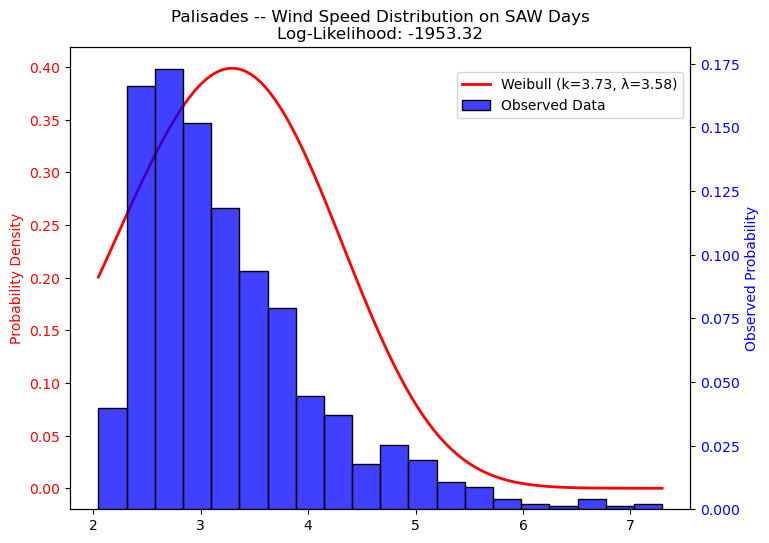

In [139]:
# Extract the relevant data
subset = analysis_df.loc[(analysis_df["fire_name"] == "Palisades") & (analysis_df["condition_1"] == 1)]
var = "wind"  # Variable to fit

# Fit Weibull distribution (MLE)
shape, loc, scale = stats.weibull_min.fit(subset[var], floc=0)  # Fix location at 0

# Generate x values for smooth curve
x = np.linspace(subset[var].min(), subset[var].max(), 100)
pdf = stats.weibull_min.pdf(x, shape, loc, scale)  # Weibull Probability Density Function

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Left y-axis: Fitted Weibull Distribution
ax1.plot(x, pdf, label=f"Weibull (k={shape:.2f}, λ={scale:.2f})", color="red", lw=2)
ax1.set_ylabel("Probability Density", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create right y-axis for observed data
ax2 = ax1.twinx()
sns.histplot(subset, x=var, stat="probability", kde=False, bins=20, label="Observed Data", color="blue", ax=ax2)
ax2.set_ylabel("Observed Probability", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Compute log-likelihood
log_likelihood = np.sum(stats.weibull_min.logpdf(subset[var], shape, loc, scale))

# Add title
plt.title(f"Palisades -- Wind Speed Distribution on SAW Days\nLog-Likelihood: {log_likelihood:.2f}")

# Move the legend inside the plot at the top-right
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))

plt.xlabel("Wind Speed (m/s)")
plt.savefig("palisades_wind_dist.png", dpi=300, bbox_inches="tight")
plt.show()

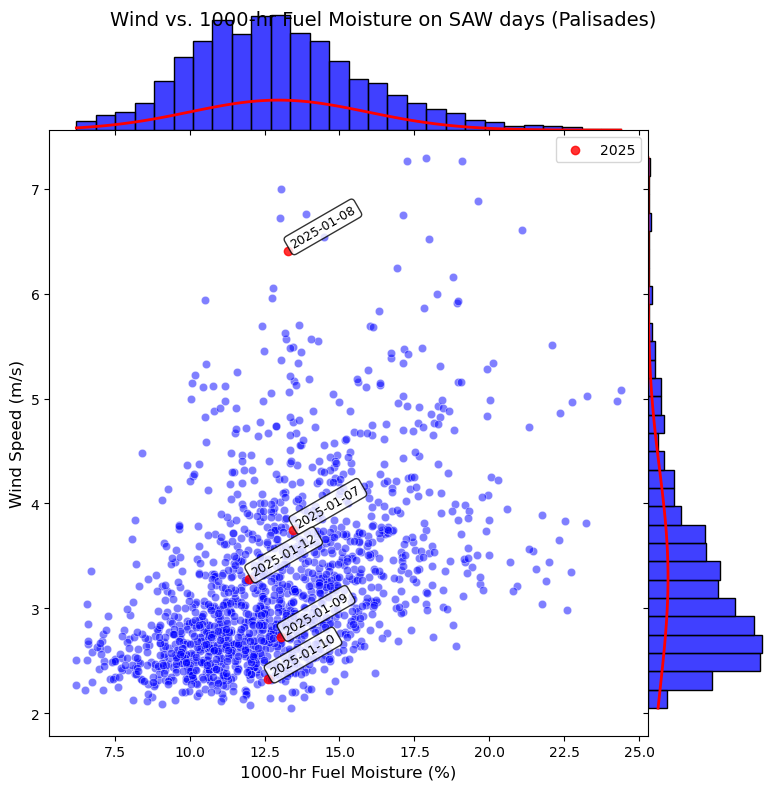

In [140]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Subset data
subset = analysis_df.loc[(analysis_df["fire_name"] == "Palisades") & (analysis_df["condition_1"] == 1)]
y_var, x_var = "wind", "fm1000"

# Separate 2025 data points
subset_2025 = subset[subset["valid_time"] >= "2025-01-01"]
subset_other = subset[subset["valid_time"] < "2025-01-01"]

# fit dfmc
mu_x, sigma_x = np.mean(subset[x_var]), np.std(subset[x_var])
x_vals = np.linspace(subset[x_var].min(), subset[x_var].max(), 100)
pdf_x = stats.norm.pdf(x_vals, mu_x, sigma_x) 

# fit wind
shape_y, loc_y, scale_y = stats.weibull_min.fit(subset[y_var], floc=0)  
y_vals = np.linspace(subset[y_var].min(), subset[y_var].max(), 100)
pdf_y = stats.weibull_min.pdf(y_vals, shape_y, loc_y, scale_y)  

# Create Joint Plot
g = sns.jointplot(data=subset_other, x=x_var, y=y_var, kind="scatter", height=8, space=0, color="blue", alpha=0.5)

# Overlay 2025 data points in red
g.ax_joint.scatter(subset_2025[x_var], subset_2025[y_var], color="red", alpha=0.8, label="2025")

# Add date labels to 2025 points
# Add date labels to 2025 points with white background and black border
for _, row in subset_2025.iterrows():
    g.ax_joint.text(
        row[x_var], row[y_var], row["valid_time"].strftime("%Y-%m-%d"), 
        fontsize=9, color="black", 
        ha='left', 
        va='bottom', 
        rotation=30,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3", alpha=0.8)
    )


ax_marg_x = g.ax_marg_x
ax_marg_x.plot(x_vals, pdf_x * np.diff(x_vals)[0] * len(subset), color="red", lw=2, label=f"Gaussian Fit (μ={mu_x:.2f}, σ={sigma_x:.2f})")
ax_marg_x.set_ylabel("Density")

ax_marg_y = g.ax_marg_y
ax_marg_y.plot(pdf_y * np.diff(y_vals)[0] * len(subset), y_vals, color="red", lw=2, label=f"Weibull Fit (k={shape_y:.2f}, λ={scale_y:.2f})")
ax_marg_y.set_xlabel("Density")

g.set_axis_labels("1000-hr Fuel Moisture (%)", "Wind Speed (m/s)", fontsize=12)
plt.suptitle("Wind vs. 1000-hr Fuel Moisture on SAW days (Palisades)", fontsize=14)
g.ax_joint.legend()
plt.savefig("palisades_joint_dist.png", dpi=300, bbox_inches="tight")
plt.show()

In [141]:
# Extract 2025-01-08 data point
target_date = "2025-01-08"
target_row = subset_2025[subset_2025["valid_time"] == target_date]

if not target_row.empty:
    target_wind = target_row[y_var].values[0]  # Wind speed value
    target_fm1000 = target_row[x_var].values[0]  # Fuel moisture value

    # Compute cumulative probabilities
    fm1000_cdf = stats.norm.cdf(target_fm1000, mu_x, sigma_x)  # P(FM1000 <= target_fm1000)
    wind_cdf = stats.weibull_min.cdf(target_wind, shape_y, loc_y, scale_y)  # P(Wind <= target_wind)

    # Compute complementary probabilities
    p_fm1000_higher = 1 - fm1000_cdf  # P(FM1000 > target_fm1000)
    p_wind_lower = wind_cdf  # P(Wind < target_wind)

    # Compute joint probability (assuming independence)
    combined_probability = (1-p_fm1000_higher) * (1-p_wind_lower)

    # Display results
    print(f"P(FM1000 < {target_fm1000:.2f}%) = {1-p_fm1000_higher:.6f}")
    print(f"P(Wind > {target_wind:.2f} m/s) = {1-p_wind_lower:.2e}")
    print(f"Combined Probability: {combined_probability:.6e}")

else:
    print(f"No data found for {target_date}.")

P(FM1000 < 13.29%) = 0.542728
P(Wind > 6.41 m/s) = 1.55e-04
Combined Probability: 8.391609e-05
